In [13]:
from llama_index import SimpleDirectoryReader, VectorStoreIndex
from llama_index.readers.file.base import (
    DEFAULT_FILE_EXTRACTOR, 
    ImageParser,
)
from llama_index.response.notebook_utils import (
    display_response, 
    display_image,
)
from llama_index.indices.query.query_transform.base import (
    ImageOutputQueryTransform,
)

In [14]:
# NOTE: By default, image parser converts image into text and discard the original image.  
#       Here, we explicitly keep both the original image and parsed text in an image document
image_parser = ImageParser(keep_image=True, parse_text=True)
file_extractor = DEFAULT_FILE_EXTRACTOR
file_extractor.update(
{
    ".jpg": image_parser,
    ".png": image_parser,
    ".jpeg": image_parser,
})

# NOTE: we add filename as metadata for all documents
filename_fn = lambda filename: {'file_name': filename}

# Q&A over Receipt Images

We first ingest our receipt images with the *custom* `image parser` and `metadata function` defined above.   
This gives us `image documents` instead of only text documents.

In [29]:
receipt_reader = SimpleDirectoryReader(
    input_dir='data/receipts', 
    file_extractor=file_extractor, 
    file_metadata=filename_fn,
)
receipt_documents = receipt_reader.load_data()

We build a simple vector index as usual, but unlike before, our index holds images in addition to text.

In [30]:
receipts_index = VectorStoreIndex.from_documents(receipt_documents)

INFO:root:> [build_index_from_documents] Total LLM token usage: 0 tokens
INFO:root:> [build_index_from_documents] Total embedding token usage: 2180 tokens


We can now ask a question that prompts for response with both text and image.  
We use a custom query transform `ImageOutputQueryTransform` to add instruction on how to display the image nicely in the notebook.

In [33]:
from llama_index.indices.query import TransformQueryEngine


query_engine = receipts_index.as_query_engine()
query_engine = TransformQueryEngine(query_engine, query_transform=ImageOutputQueryTransform(width=400))
receipts_response = query_engine.query(
    'When was the last time I went to McDonald\'s and how much did I spend. \
    Also show me the receipt from my visit.',
)

INFO:root:> [query] Total LLM token usage: 1005 tokens
INFO:root:> [query] Total embedding token usage: 30 tokens


We now have rich multimodal response with inline text and image!  

The source nodes section gives additional details on retrieved data used for synthesizing the final response.  
In this case, we can verify that the receipt for McDonald's is correctly retrieved. 

**`Final Response:`** The last time you went to McDonald's was on 03/10/2018 at 07:39:12 PM and you spent $26.15. Here is the receipt from your visit: <img src="data/receipts/1100-receipt.jpg" width="400" />

---

**`Source Node 1/1`**

**Document ID:** 3949d7d1-96bc-4d46-beb6-79d2acbb1fd6<br>**Similarity:** 0.7981321083637717<br>**Text:** file_name: data/receipts/1100-receipt.jpg

<s_menu><s_nm> Story</s_nm><s_num> 16725 Stony Platin ...<br>**Image:**

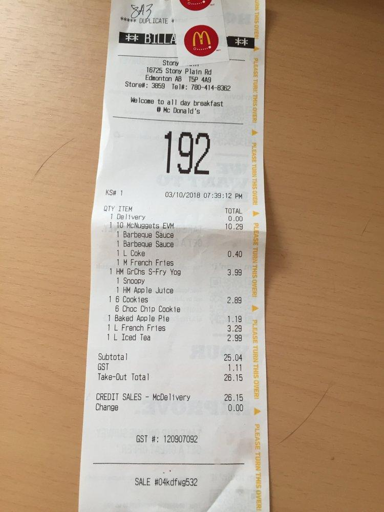

In [34]:
display_response(receipts_response)

# Q & A over LlamaIndex Documentation

We now demo the same for Q&A over LlamaIndex documentations.   
This demo higlights the ability to synthesize multimodal output with a mixture of text and image documents

In [15]:
llama_reader = SimpleDirectoryReader(
    input_dir='data/llama',
    file_extractor=file_extractor, 
    file_metadata=filename_fn,
)
llama_documents = llama_reader.load_data(concatenate=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [16]:
llama_index = VectorStoreIndex.from_documents(llama_documents)

INFO:root:> [build_index_from_documents] Total LLM token usage: 0 tokens
INFO:root:> [build_index_from_documents] Total embedding token usage: 965 tokens


In [19]:
from llama_index.indices.query import TransformQueryEngine


query_engine = llama_index.as_query_engine(
    similarity_top_k=2
)
query_engine = TransformQueryEngine(query_engine, query_transform=ImageOutputQueryTransform(width=400))
llama_response = query_engine.query(
    'Show an image to illustrate how tree index works and explain briefly.', 
)

INFO:root:> [query] Total LLM token usage: 1592 tokens
INFO:root:> [query] Total embedding token usage: 13 tokens


By inspecting the 2 source nodes, we see relevant text and image describing the tree index are retrieved for synthesizing the final multimodal response.

**`Final Response:`** Tree index is a data structure that organizes data in a hierarchical structure. It is often used to store and retrieve data quickly. The image below illustrates how tree index works. 

<img src="data/llama/tree_index.png" width="400" />

At the top of the tree is the root node, which contains the main data. From the root node, the data is divided into smaller nodes, which are called child nodes. Each child node can have its own child nodes, and so on. To retrieve data, the tree index is traversed from the root node to the desired node. This allows for quick retrieval of data.

In addition, LlamaIndex offers different methods of synthesizing a response from the tree index. The way to toggle this can be found in our Usage Pattern Guide. For example, the "Create and Refine" mode is an iterative way of generating a response. We first use the context in the first node, along with the query, to generate an initial answer. We then pass this answer, the query, and the context of the second node as input into a "refine prompt" to generate a refined answer. We refine through N-1 nodes, where

---

**`Source Node 1/2`**

**Document ID:** 589f9b15-f3b4-4bfc-b50e-28fb1a2d0173<br>**Similarity:** 0.8151716742235475<br>**Text:** file_name: data/llama/tree_index.png

<s_menu><s_nm> Root Node</s_nm><s_unitprice> Parent</s_nm><...<br>**Image:**

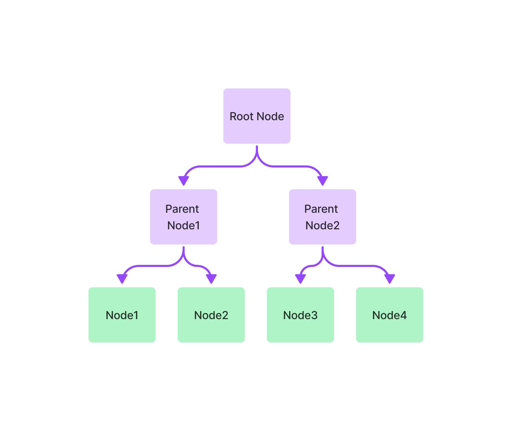

---

**`Source Node 2/2`**

**Document ID:** d60e5289-64c9-4446-91be-afca6c2be723<br>**Similarity:** 0.8133374944584655<br>**Text:** How Each Index Works

This guide describes how each index works with diagrams. We also visually h...<br>

In [20]:
display_response(llama_response)

We show another example asking about vector store index instead.

In [17]:
llama_response = query_engine.query(
    'Show an image to illustrate how vector store index works and explain briefly.', 
)

INFO:root:> [query] Total LLM token usage: 1567 tokens
INFO:root:> [query] Total embedding token usage: 14 tokens


**`Final Response:`** Vector store index is a data structure used to store and retrieve data efficiently. It is a type of hash table that uses a hash function to map keys to their associated values. The image below illustrates how vector store index works. 

<img src="data/llama/vector_store_index.png" width="400" />

In the image, the keys are represented by the numbers on the left side of the table, and the values are represented by the numbers on the right side. The hash function is used to map the keys to their associated values. The hash function takes the key as input and produces an index, which is used to locate the value in the table.

Vector store index is one of the four index types used by LlamaIndex, a search engine for natural language processing. The other three index types are list index, tree index, and keyword table index. Each index type has its own way of storing and retrieving data. 

List index stores Nodes as a sequential chain. During query time, if no other query parameters are specified, LlamaIndex simply loads all Nodes in the list into our Reponse Synthesis module. The list index also offers numerous ways of querying a list

---

**`Source Node 1/2`**

**Document ID:** 80d8d2e9-412f-4b22-bc60-55dd131b73a9<br>**Similarity:** 0.8164705784668993<br>**Text:** file_name: data/llama/vector_store_index.png

<s_menu><s_nm> Nodel</s_nm><s_unitprice> Node2</s_u...<br>**Image:**

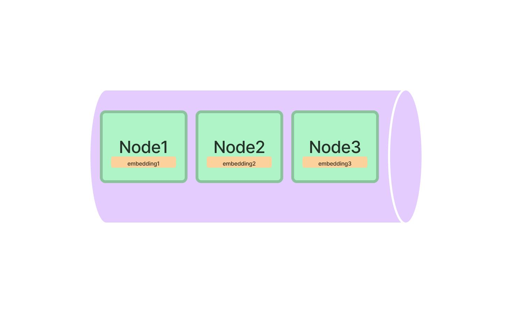

---

**`Source Node 2/2`**

**Document ID:** d60e5289-64c9-4446-91be-afca6c2be723<br>**Similarity:** 0.7878578850577496<br>**Text:** How Each Index Works

This guide describes how each index works with diagrams. We also visually h...<br>

In [18]:
display_response(llama_response)